# Data PreProcessing

In [260]:
import sys
sys.path.append('/Users/mac/Desktop/Desktop_Files/Projects/Zomato Restaurant Rating Prediction')


In [261]:
# Prevent WARNINGS!
import warnings
warnings.filterwarnings('ignore')

In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from utility.utils import analyze_corr, convert_cat
import scipy.stats as stats
from scipy.stats import zscore


In [263]:
## laoding the dataset (EDA_final_cleaned.pkl)
import joblib
df = joblib.load("../artifacts/EDA_final_cleaned.pkl")

In [264]:
df.head(2)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost,reviews_list,menu_item,type,city,rating_group,cuisines_list
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,1,1,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,3 to 4.2,"[North Indian, Mughlai, Chinese]"
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,1,0,4.1,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari,3 to 4.2,"[Chinese, North Indian, Thai]"


#### Categorical Conversion

In [265]:
## dropping cuisine column as it is not categorical->
df = df.drop(columns=['cuisines'], axis=1)

Note-> The dtype will still be int because we are also puttin integer codes for those categoricla columns 
- u can check the utils.py file having convert_cat fucntion with .cat.codes feature in it.

In [266]:
## converting  columns to category dtype
col_list = ['online_order', 'book_table', 'location', 'rest_type', 'type', 'city']
df = convert_cat(df, col_list)


In [267]:
df[col_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41665 entries, 0 to 41664
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   online_order  41665 non-null  int8 
 1   book_table    41665 non-null  int8 
 2   location      41665 non-null  int8 
 3   rest_type     41665 non-null  int8 
 4   type          41665 non-null  int8 
 5   city          41665 non-null  int8 
dtypes: int8(6)
memory usage: 244.3 KB


In [268]:
df['approx_cost'].sample(5)

1136     200
8740     600
1854     200
21786    600
12316    150
Name: approx_cost, dtype: int64

### Outliers Detection->

In [269]:
## Function to check for outliers using IQR method
def check_outliers(df, col):
    s = df[col]   ## selecting the series (column)

    # calculatin both quartiles
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1

    # bounds
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr

    # Vectorized checks for outliers
    has_lower = (s < lower_bound).any()
    has_upper = (s > upper_bound).any()

    # Print summary
    print(f"IQR: {iqr}")
    print(f"Lower cutoff: {lower_bound}")
    print(f"Upper cutoff: {upper_bound}\n")

    print("Lower Side:", "Outliers present 🚩" if has_lower else "No outliers ✅")
    print("Upper Side:", "Outliers present 🚩" if has_upper else "No outliers ✅")




In [270]:
check_outliers(df, 'approx_cost')

IQR: 300.0
Lower cutoff: -250.0
Upper cutoff: 950.0

Lower Side: No outliers ✅
Upper Side: No outliers ✅


- Fortunately, our data has no outliers for "approx_cost" column

Let's check for all other columns->

In [271]:
#df.head(2)

In [272]:
# online_order 
# check_outliers(df, 'online_order' ) # obv no outliers bcz categorical

In [273]:
## check_outliers(df, 'rate' )

### Outlier Detection in DataFrame Columns->

In [274]:
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        print(f"Checking outliers for column: {col}")
        check_outliers(df, col)
        print("-" * 40)

Checking outliers for column: rate
IQR: 0.6000000000000001
Lower cutoff: 2.5
Upper cutoff: 4.9

Lower Side: Outliers present 🚩
Upper Side: No outliers ✅
----------------------------------------
Checking outliers for column: votes
IQR: 255.0
Lower cutoff: -361.5
Upper cutoff: 658.5

Lower Side: No outliers ✅
Upper Side: Outliers present 🚩
----------------------------------------
Checking outliers for column: approx_cost
IQR: 300.0
Lower cutoff: -250.0
Upper cutoff: 950.0

Lower Side: No outliers ✅
Upper Side: No outliers ✅
----------------------------------------


- "rate" and "votes" column has Outliers

### Let's verify it using visuals;

In [275]:
# Separating Numerical & Categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=['int64']).columns
# 
# print(f"We have {len(categorical_columns)} categorical columns in our dataframe")
# print('Categorical columns are: ',categorical_columns)
# print('\n')
# print("We have {} numerical columns in our dataframe".format(len(numerical_columns)))
# print('Numerical_columns are: ',numerical_columns)

In [276]:
# # Identifying the outliers present in numerical columns using boxplot
# plt.figure(figsize=(10,10))
# plotnumber=1
# for col in numerical_columns:
#     if plotnumber<=4:
#         ax=plt.subplot(2,2,plotnumber)                        # too simple plots, updating later (ChatGPT) with better visualizations
#         sns.boxplot(x=col, data=df,color='brown')
#         plt.xlabel(col,fontsize=12)
#     plotnumber+=1
# plt.tight_layout()


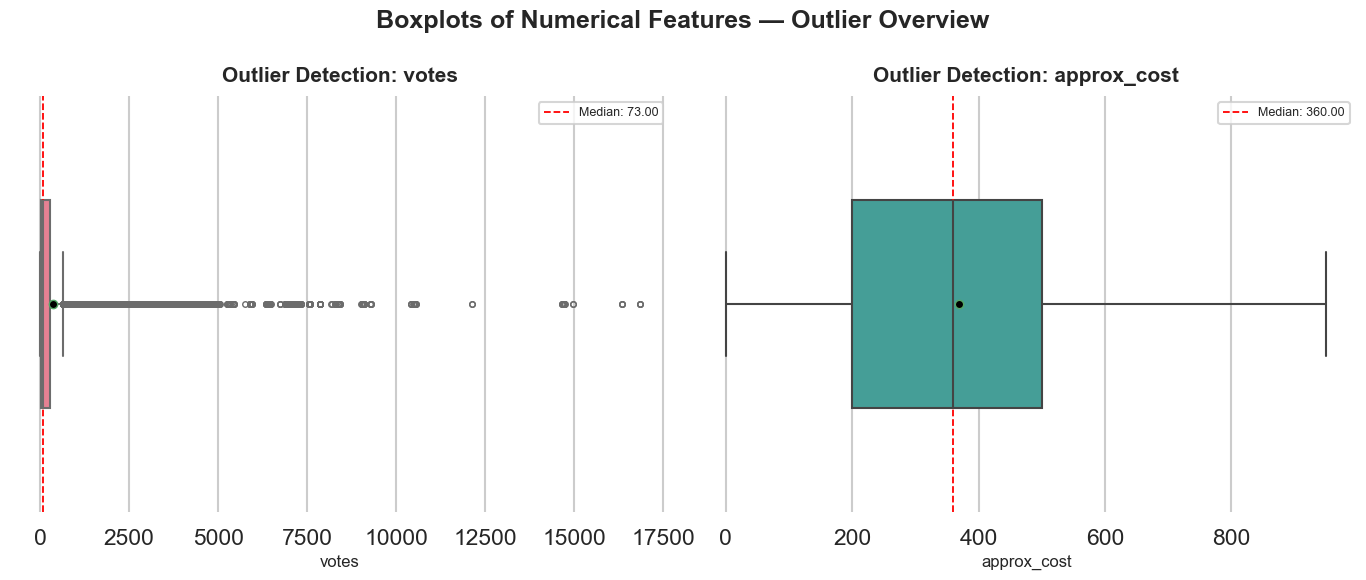

In [277]:
sns.set_theme(style="whitegrid", context="talk")

# Prepare responsive figure
plt.figure(figsize=(14, 10))
plot_num = 1
palette = sns.color_palette("husl", len(numerical_columns))  # vibrant but balanced colors

for col, color in zip(numerical_columns, palette):
    if plot_num <= 4:
        plt.subplot(2, 2, plot_num)
        
        # Create a sleek horizontal boxplot with subtle styling
        sns.boxplot(
            x=df[col],
            color=color,
            width=0.5,
            linewidth=1.5,
            fliersize=4,
            showmeans=True,
            meanprops={"marker": "o", "markerfacecolor": "black", "markersize": 6},
        )
        
        # Design polish
        plt.title(f"Outlier Detection: {col}", fontsize=15, weight='bold', pad=10)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("")
        
        # Add median annotation
        median = df[col].median()
        plt.axvline(median, color="red", linestyle="--", lw=1.3, label=f"Median: {median:.2f}")
        plt.legend(fontsize=9, loc="upper right", frameon=True)
        
        # Clean look
        sns.despine(left=True, bottom=True)
        
        plot_num += 1

plt.tight_layout()
plt.suptitle("Boxplots of Numerical Features — Outlier Overview", fontsize=18, weight="bold", y=1.03)
plt.savefig('../visualizations/reports/numerical_features_outliers.png', bbox_inches='tight')
plt.show()


- Clearly, Votes has Outliers on its Upper Bound

In [278]:
numerical_columns_new = ['votes','approx_cost', "rate"]
df[numerical_columns_new] = df[numerical_columns_new]
old_df_shape = df.shape
old_df_shape

(41665, 18)

In [279]:
#df.head()

### Outlier Treatmnet
- Using Z-Score method to handle outliers, 

In [280]:
# Calculate the z-scores for the specified numerical columns
z = np.abs(zscore(df[numerical_columns_new]))

# Create a new DataFrame df1 with rows where z-scores are less than 3 for all numerical columns
df1 = df[(z < 3).all(axis=1)]
new_df_shape = df1.shape
new_df_shape

(40729, 18)

#### Verifying, 
- if the outliers have been removed

In [281]:
# checkin if outliers are removed or not
for col in df1.columns:
    if df1[col].dtype in ['int64', 'float64']:
        print(f"Checking outliers for column: {col}")
        check_outliers(df1, col)
        print("-" * 40)

Checking outliers for column: rate
IQR: 0.6000000000000001
Lower cutoff: 2.5
Upper cutoff: 4.9

Lower Side: Outliers present 🚩
Upper Side: No outliers ✅
----------------------------------------
Checking outliers for column: votes
IQR: 230.0
Lower cutoff: -324.0
Upper cutoff: 596.0

Lower Side: No outliers ✅
Upper Side: Outliers present 🚩
----------------------------------------
Checking outliers for column: approx_cost
IQR: 300.0
Lower cutoff: -250.0
Upper cutoff: 950.0

Lower Side: No outliers ✅
Upper Side: No outliers ✅
----------------------------------------


### Still it has Outliers, 
- means, our data must have skewness in them, thatswhy Z-Score couldnt handle outliers here.
- Or, maybe bcz of "rate" column because ratings can’t go below 0 or above 5, so the mean & SD-based logic doesn’t fit. IQR still found lower outliers (maybe a bunch of 2.5s far below the median). Lets use IQR after viewing Skewness. 

#### Dataloss Calculation

In [282]:
# checking the data loss for zscore
data_loss_zscore = ((old_df_shape[0] - new_df_shape[0]) / old_df_shape[0]) * 100 # data loss in % percentage
print('Dataloss using zscore:',np.round(data_loss_zscore,2),"%")

Dataloss using zscore: 2.25 %


- 2.25%? This is bearable! We will continue our PreProcessing now

## Skewness detection & Treatment

In [283]:
## setting df1 as df for further preprocessing and 
# also selecting only the required columns for modeling
df = df1[['votes','approx_cost', "rate"]]
df.head(2)

,votes,approx_cost,rate
0,775,800,4.1
1,787,800,4.1


## Drop Irrelevant Columns->

- instead of dropping here we have already selected only required columns above

In [284]:
## drop Irrelevant Columns-> 
# irrelevant_columns = ['url', 'address', 'name', 'phone', 'book_table',] 

# # instead of dropping here we have already selected only required columns above
# df = df.drop(columns=irrelevant_columns, axis=1)
# df.head(2)

In [285]:
# ## creating a new column "Price_Range" based on the "approx_cost" column
# df['Price_Range'] = pd.cut(df['approx_cost'], bins=[0, 500, 1000, 1500, 2000, np.inf], labels=['0-500', '500-1000', '1000-1500', '1500-2000', '2000+'])
# df.head(2)

In [286]:
df['rating'] = df['rate']
df = df.drop(columns=['rate'], axis=1)

In [287]:
df.skew()

votes          3.064601
approx_cost    0.150623
rating        -0.301479
dtype: float64

- hmm! But still, Lets Visualize it more for clarity;

In [288]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

### Visualizing Skewness

In [289]:
# Visualizing it
# plt.figure(figsize=(10,6))
# plotnum=1
# for col in numerical_columns:
#     if plotnum<=5:
#         plt.subplot(3,2,plotnum)                  # too simple plots, updating later (ChatGPT) with better visualizations
#         sns.distplot(df[col])
#         plt.xlabel(col,fontsize=12)
#     plotnum+=1
# plt.show()

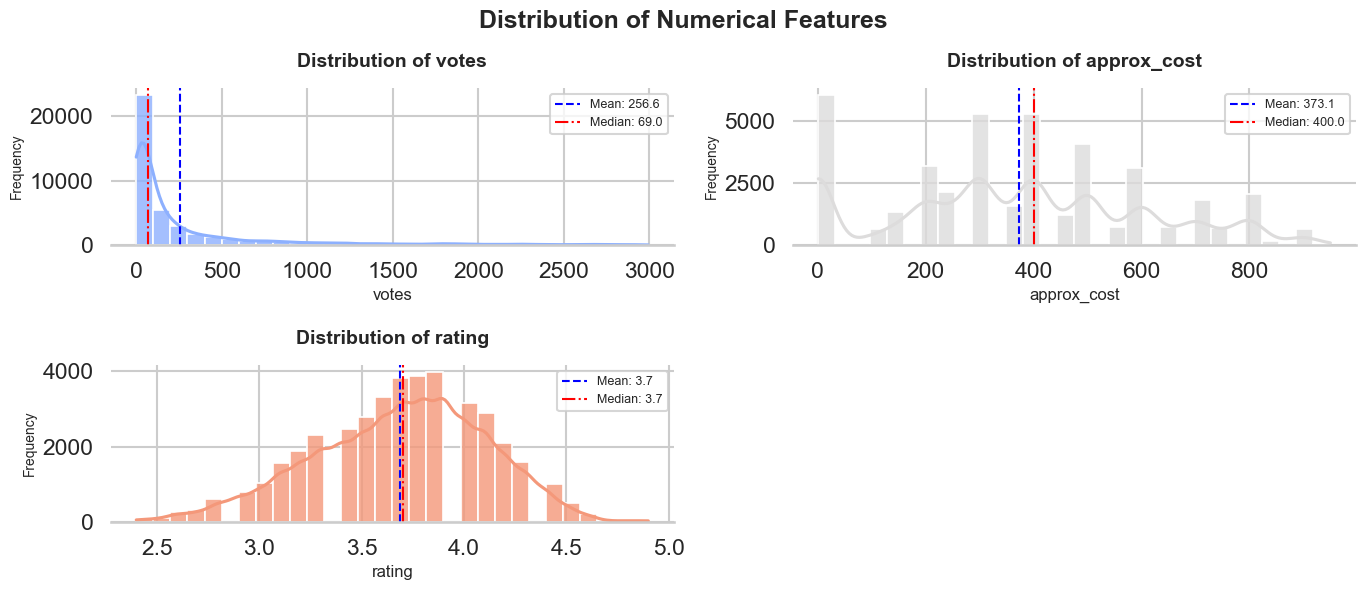

In [290]:
sns.set_theme(style="whitegrid", context="talk")

# Create figure canvas
plt.figure(figsize=(14, 8))
plotnum = 1
palette = sns.color_palette("coolwarm", len(numerical_columns))

for col, color in zip(numerical_columns, palette):
    if plotnum <= 6:  # Limit number of plots
        plt.subplot(3, 2, plotnum)
        
        # Distribution with KDE and transparency for smooth look
        sns.histplot(df[col], kde=True, color=color, bins=30, alpha=0.8, edgecolor='white', linewidth=1.2)
        
        # Add mean and median lines for interpretability
        mean_val = df[col].mean()
        median_val = df[col].median()
        plt.axvline(mean_val, color='blue', linestyle='--', lw=1.5, label=f'Mean: {mean_val:.1f}')
        plt.axvline(median_val, color='red', linestyle='-.', lw=1.5, label=f'Median: {median_val:.1f}')
        
        # Titles and labels
        plt.title(f'Distribution of {col}', fontsize=14, weight='bold', pad=15)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Frequency', fontsize=10)
        plt.legend(frameon=True, fontsize=9, loc='upper right')
        
        sns.despine(left=True)  # Removes unnecessary borders
        
        plotnum += 1

plt.tight_layout()
plt.suptitle("Distribution of Numerical Features", fontsize=18, weight="bold", y=1.02)
plt.savefig('../visualizations/reports/numerical_features_distribution.png', bbox_inches='tight')
plt.show()



In [295]:
## making copy of df for personal curiosity part 🥸
df_curiosity = df.copy()

## Treating Skewness 
### Log Transformation Technique

- Machine learning algorithms don't like that imbalance because those big numbers dominate the patterns.
- So we apply a logarithmic transformation to “compress” those gigantic values

In [291]:
# using log transformation to remove skewness from the votes
df['votes'] = np.log1p(df['votes']) # log1p is used to handle log(0) issue, making the distribution more normal


#### Why not just "np.log(df['votes']).. 
- Ans; ( I am wrtitng this for my own information and Learning, will remove later)

- Because np.log() doesn’t work if we have zeros!
- If there’s even a single 0 in our data, it will crash:
- np.log(0) = ❌  "math error" (because log(0) = -∞) 

- Theory part; 

log1p is a numpy function that computes log(1 + x).
- That’s why we use log1p — a safety version of log
np.log1p(x) means log(1 + x) behind the scenes.

- So if your value was:

0 → log(1 + 0) = 0 (not a problem) but if it was log(0) it was a problem then. 

5 → log(1 + 5) = log(6)

### Handling outliers again,
- with the same Z-Score method as we've already fixed the Skewness

In [293]:
numerical_columns_new = ['votes','approx_cost', "rating"]
df[numerical_columns_new] = df[numerical_columns_new]
z = np.abs(zscore(df[numerical_columns_new]))

# Create a new DataFrame df1 with rows where z-scores are less than 3 for all numerical columns
df1 = df[(z < 3).all(axis=1)]
new_df_shape = df1.shape
new_df_shape

(40659, 3)

#### Verifying Again->

In [294]:
# checkin if outliers are removed or not
for col in df1.columns:
    if df1[col].dtype in ['int64', 'float64']:
        print(f"Checking outliers for column: {col}")
        check_outliers(df1, col)
        print("-" * 40)

Checking outliers for column: votes
IQR: 2.4423470353692043
Lower cutoff: -0.5724780996954904
Upper cutoff: 9.196910041781326

Lower Side: No outliers ✅
Upper Side: No outliers ✅
----------------------------------------
Checking outliers for column: approx_cost
IQR: 300.0
Lower cutoff: -250.0
Upper cutoff: 950.0

Lower Side: No outliers ✅
Upper Side: No outliers ✅
----------------------------------------
Checking outliers for column: rating
IQR: 0.6000000000000001
Lower cutoff: 2.5
Upper cutoff: 4.9

Lower Side: No outliers ✅
Upper Side: No outliers ✅
----------------------------------------


### Done😏, 
- Note-> I could've also done the Outlier handling with IQR directly but eventually skewness was needed to be taken care of. So..!

### Personal Curiosity->

- lets check if i've done the outlier removal without handling skewness but using IQR method->

In [297]:
## I've already made a copy of skewed DF before handling skewness for this personal curiosity part 🥸
df_curiosity.skew()

votes          0.202048
approx_cost    0.150623
rating        -0.301479
dtype: float64

In [299]:
def remove_iqr_outliers(df_curiosity, col):
    Q1 = df_curiosity[col].quantile(0.25)
    Q3 = df_curiosity[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    return df_curiosity[(df_curiosity[col] >= lower) & (df_curiosity[col] <= upper)]

for col in numerical_columns_new:
    df_curiosity_check = remove_iqr_outliers(df_curiosity, col)

#### Verifying this too->

In [300]:
# checkin if outliers are removed or not
for col in df_curiosity_check.columns:
    if df_curiosity_check[col].dtype in ['int64', 'float64']:
        print(f"Checking outliers for column: {col}")
        check_outliers(df_curiosity_check, col)
        print("-" * 40)

Checking outliers for column: votes
IQR: 2.4423470353692043
Lower cutoff: -0.5724780996954904
Upper cutoff: 9.196910041781326

Lower Side: No outliers ✅
Upper Side: No outliers ✅
----------------------------------------
Checking outliers for column: approx_cost
IQR: 300.0
Lower cutoff: -250.0
Upper cutoff: 950.0

Lower Side: No outliers ✅
Upper Side: No outliers ✅
----------------------------------------
Checking outliers for column: rating
IQR: 0.6000000000000001
Lower cutoff: 2.5
Upper cutoff: 4.9

Lower Side: No outliers ✅
Upper Side: No outliers ✅
----------------------------------------


### Satisfactionn!!🫡